# Q1

## (a)

In [16]:
import pandas as pd
data = pd.read_csv('housing.csv')
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

X, y = data.iloc[:, :-1], data.iloc[:, -1]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0
5039,-118.34,33.99,34.0,397.0,132.0,250.0,121.0,1.6750,166700.0
10341,-117.80,33.78,17.0,4138.0,805.0,2442.0,780.0,4.7804,242000.0
16325,-121.33,37.98,10.0,1564.0,397.0,643.0,347.0,2.7031,150000.0
10209,-117.92,33.88,32.0,1683.0,273.0,719.0,263.0,5.3649,243600.0


We need to stratify here since longitude and latitude are key factors that determine ocean proximity. Besides, ISLAND only has five samples in the whole set. Therefore, we need to stratify to ensure that each subgroup is adequately represented in the training and testing datasets.

## (b)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

pre_process_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Step 1: Imputation
    ('std_scaler', StandardScaler()),               # Step 2: Standardizing
])

## (c) 

In [19]:
full_pipeline = Pipeline([
    # include the predefined pre processing block
    ('preprocessing', pre_process_pipeline),    
    # Step 3: include a KNN classifier with minkowski metric
    ('knn', KNeighborsClassifier(metric='minkowski', weights='uniform', n_neighbors=5))
])

## (d) 

In [22]:
from sklearn.metrics import accuracy_score

def test_p_norm(p_norm):
    full_pipeline = Pipeline([
        ('preprocessing', pre_process_pipeline),           
        ('knn', KNeighborsClassifier(metric='minkowski', p=p_norm, weights='uniform', n_neighbors=5))
    ])
    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

for i in [1,2,10]:
    acc = test_p_norm(i)
    print('Under L{} norm, predict accuracy on the test set is {}'.format(i,acc))

Under L1 norm, predict accuracy on the test set is 0.8330910852713178
Under L2 norm, predict accuracy on the test set is 0.812015503875969
Under L10 norm, predict accuracy on the test set is 0.7928779069767442


As p increases, the prediction accuracy declines, implying that greater sensitivity to large differences does not improve the model's performance here. 

Note that $p=-10$ is unfeasile here as the Minkowski distance requires $p$ larger than 1. Otjerwise an error would be raised.

## (e) 

In [9]:
from sklearn.model_selection import GridSearchCV 

param_grid = {'knn__p': [1+ 0.05 * i for i in range(0, 100)]}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best p: ', best_params)
print('Best accuracy: ', best_score)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best p:  {'knn__p': 1.0}
Best accuracy:  0.828548934108527


## (f)

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class drop_feature(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop
    
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        if self.features_to_drop:
            return X.drop(self.features_to_drop, axis=1)
        return X

accuracy_change = {}
all_features = X_train.columns.tolist()

# Evaluate the model's performance when we drop one of the features
for feature in all_features:
    drop_pipeline = Pipeline([
        ('drop_feature', drop_feature(features_to_drop=[feature])), 
        ('preprocessing', pre_process_pipeline), 
        ('knn', KNeighborsClassifier(metric='minkowski', p=1, weights='uniform'))
    ])
    
    # Train the model
    drop_pipeline.fit(X_train, y_train)
    
    # Evaluate accuracy on test set
    y_pred = drop_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate the change in accuracy compared to the original
    accuracy_change[feature] = accuracy - best_score

# Find the feature whose removal caused the biggest drop in accuracy
most_important_feature = min(accuracy_change, key=accuracy_change.get)
acc_pct_drop = -accuracy_change[most_important_feature] * 100
print('Most important feature is ' + most_important_feature)
print('Without this feature, prediction accuracy drop by '+ str(round(acc_pct_drop,2))+'%.')
accuracy_change

Most important feature is longitude
Without this feature, prediction accuracy drop by 5.97%.


{'longitude': -0.0596535852713177,
 'latitude': -0.05626211240310064,
 'housing_median_age': 0.014958817829457516,
 'total_rooms': 0.004784399224806335,
 'total_bedrooms': 0.00987160852713187,
 'population': 0.008660368217054404,
 'households': 0.011082848837209447,
 'median_income': 0.02053052325581406,
 'median_house_value': -0.005390019379844846}

# Q2

## (a)

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel('prices_daily.xlsx', index_col=0)
df.fillna(method='bfill',inplace=True)

weekly_data = df.resample('W').mean()
weekly_data

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS10,DGS20,DGS30
DATE,,,,,,,,,,
2001-01-07,3.670,5.584,5.356,4.936,4.798,4.782,4.788,4.988,5.520,5.408
2001-01-14,3.670,5.272,5.142,4.788,4.722,4.734,4.806,5.082,5.612,5.504
2001-01-21,3.670,5.328,5.206,4.872,4.818,4.822,4.874,5.196,5.660,5.550
2001-01-28,3.670,5.240,5.116,4.826,4.788,4.812,4.936,5.292,5.746,5.636
2001-02-04,3.670,5.036,4.908,4.658,4.658,4.704,4.874,5.204,5.652,5.558
...,...,...,...,...,...,...,...,...,...,...
2022-12-04,4.042,4.366,4.688,4.726,4.370,4.112,3.794,3.632,3.926,3.710
2022-12-11,3.830,4.322,4.724,4.720,4.330,4.056,3.722,3.516,3.760,3.512
2022-12-18,3.910,4.342,4.708,4.658,4.248,3.974,3.666,3.506,3.748,3.526


In [3]:
weekly_data.to_csv('prices.csv', index=False)

## (b)

In [4]:
from sklearn.model_selection import TimeSeriesSplit

class RolledTimeSeriesSplit(TimeSeriesSplit):
    def __init__(self, n_splits=5, test_size=None, train_test_ratio=None):
        super().__init__(n_splits=n_splits,test_size=test_size)
        self.train_test_ratio = train_test_ratio

    def split(self, X, y=None):
        for train_index, test_index in super().split(X, y):
            if self.train_test_ratio is None:
                yield train_index, test_index
            else:
                # Calculate maximum training size 
                max_train_size = int(np.floor(self.train_test_ratio * len(test_index)))
                if len(train_index) > max_train_size:
                    yield train_index[-max_train_size:], test_index
                else:
                    yield train_index, test_index

## (c) 

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class MyPCA(PCA):
    def __init__(self, n_components=None, plot=False):
        super().__init__(n_components=n_components)
        self.plot = plot

    def fit(self, X, y=None): 
        # X is a dataframe indexed by date
        super().fit(X)
        # If plot is True, call the plot_components method
        if self.plot:
            self.plot_components(X.columns)
        return self

    def plot_components(self, columns):
        plt.figure(figsize=(10,5))
        for i, component in enumerate(self.components_, start=1):
            plt.plot(component, label=f'Component {i}')
        
        plt.ylabel('Component Loadings')
        plt.xticks(range(len(columns)), columns, rotation=90) 
        plt.title(f'Explained Variance Ratio is: {sum(self.explained_variance_ratio_)}')
        plt.legend()
        plt.tight_layout()
        plt.show()

## (d) 

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class Rolled_TS_PCA(BaseEstimator, TransformerMixin):
    def __init__(self,n_components=None, plot=False, n_splits=5, test_size=None, train_test_ratio=None):
        self.n_components = n_components
        self.plot = plot
        self.n_splits = n_splits
        self.test_size = test_size
        self.train_test_ratio = train_test_ratio
        self.variance_explained_his = []


    def fit(self, X, y=None):
        RTS = RolledTimeSeriesSplit(n_splits=self.n_splits, test_size=self.test_size, train_test_ratio=self.train_test_ratio)
        

        self.myPCA = MyPCA(n_components=self.n_components, plot=self.plot)
        
        # Iterate through and fit PCA to each training set
        for train_index, test_index in RTS.split(X):
            X_train = X.iloc[train_index]
            self.myPCA.fit(X_train)
            self.variance_explained_his.append(sum(self.myPCA.explained_variance_ratio_))
        return self

    def transform(self, X,y=None):
        return self.myPCA.transform(X)
    
class get_diff(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        return self
    def transform(self,X,y=None):
        temp = X - X.shift(1)
        temp.drop(temp.index[0], inplace=True)
        return temp

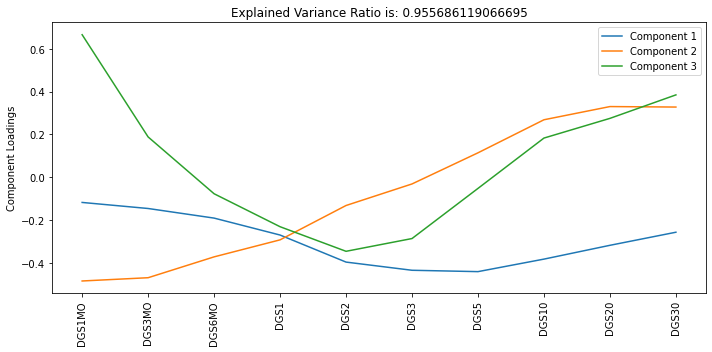

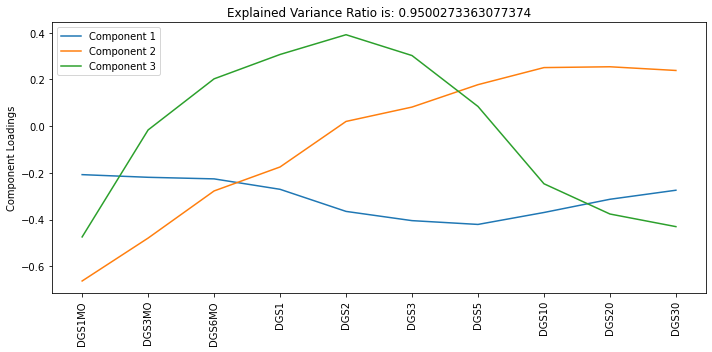

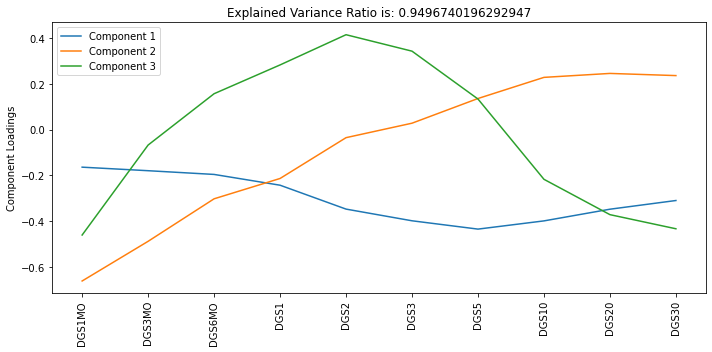

Pipeline(steps=[('get change', get_diff()),
                ('ts_pca',
                 Rolled_TS_PCA(n_components=3, n_splits=3, plot=True,
                               train_test_ratio=3))])

In [7]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('get change', get_diff()), 
    ('ts_pca', Rolled_TS_PCA(n_splits=3, train_test_ratio=3, n_components=3, plot=True))
])

pipeline.fit(weekly_data)

## (e) 

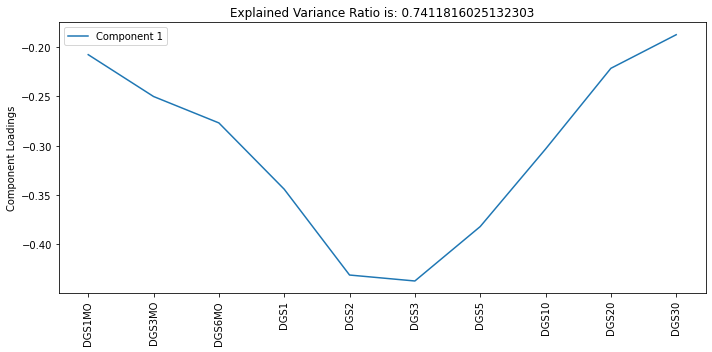

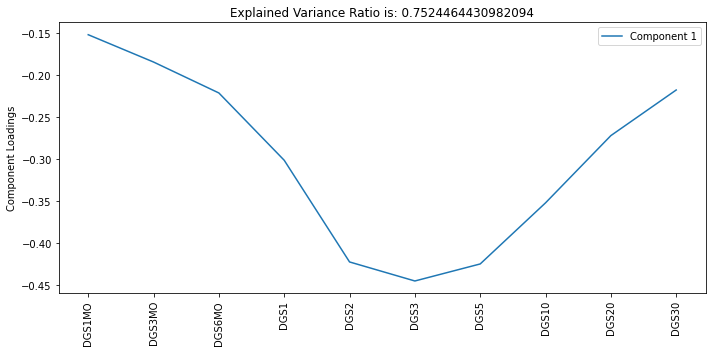

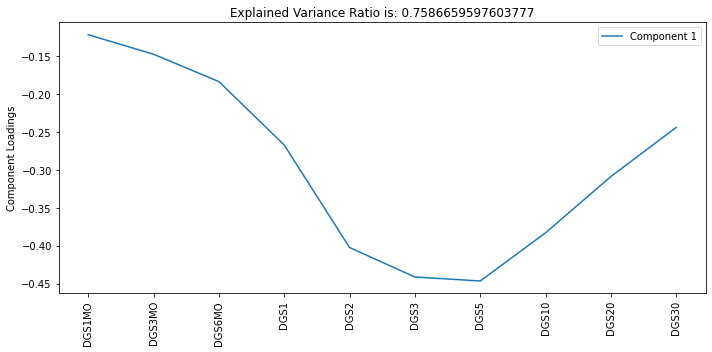

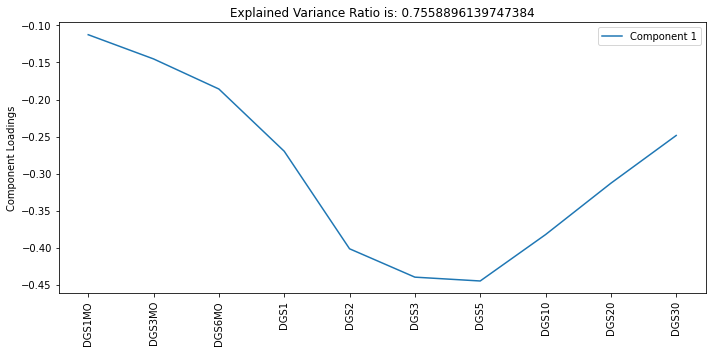

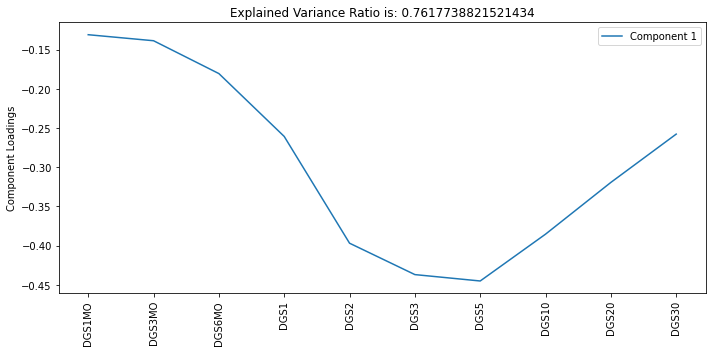

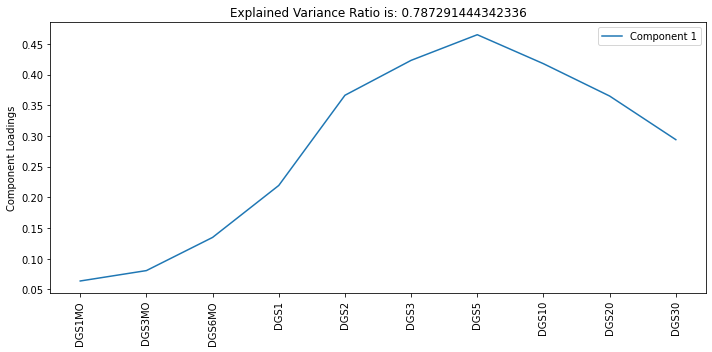

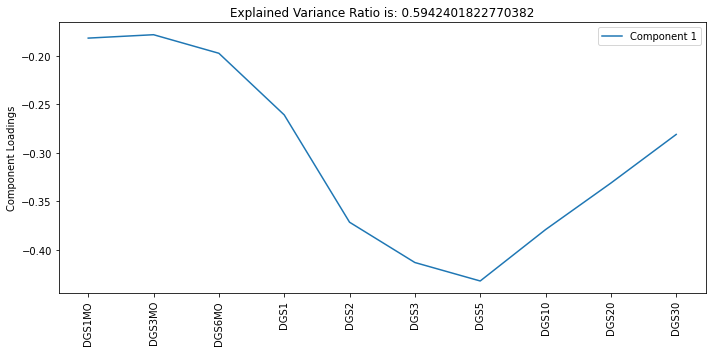

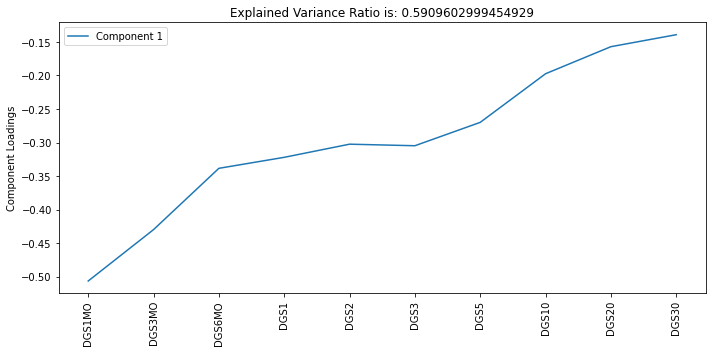

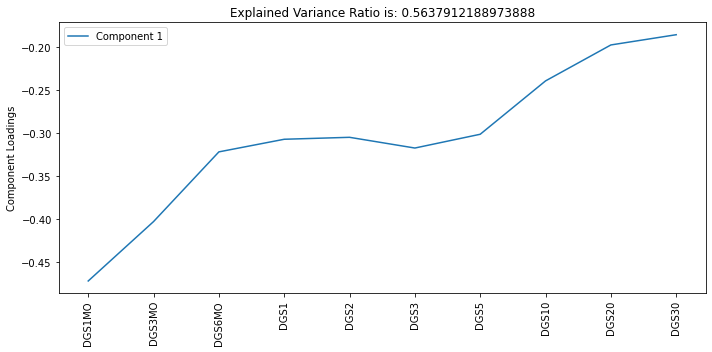

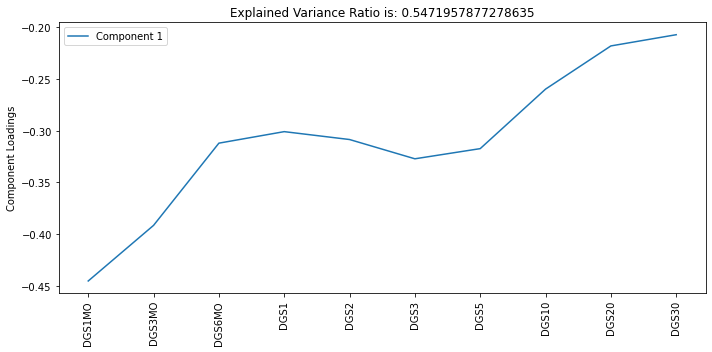

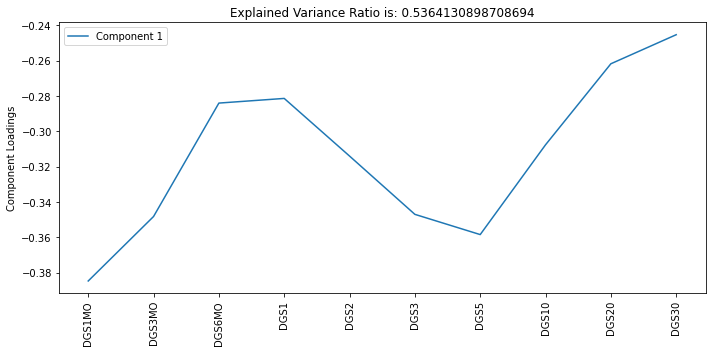

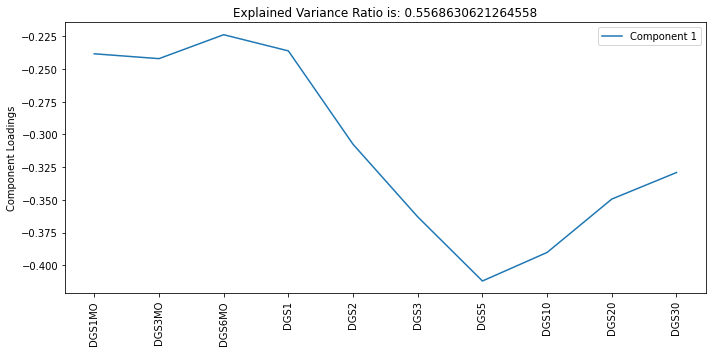

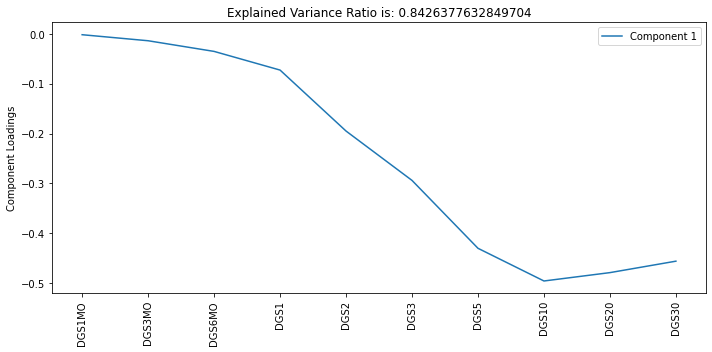

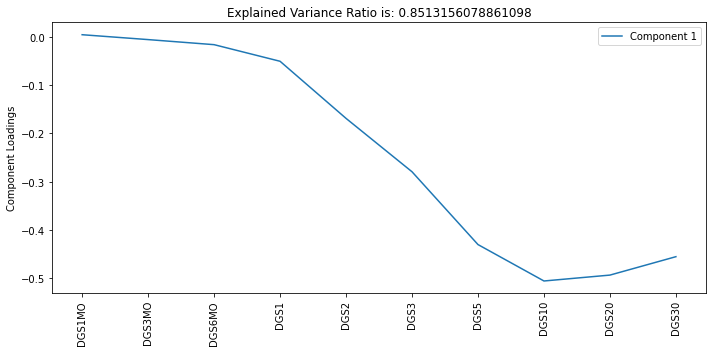

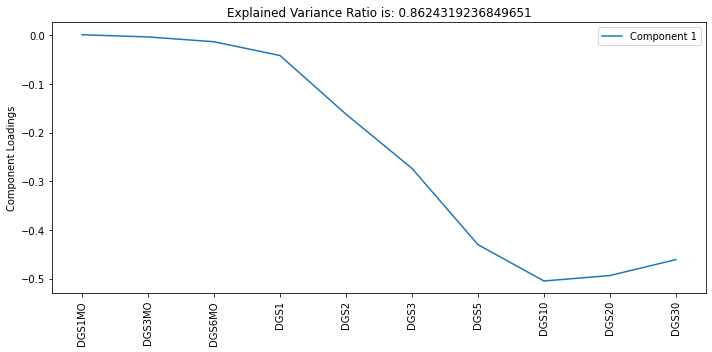

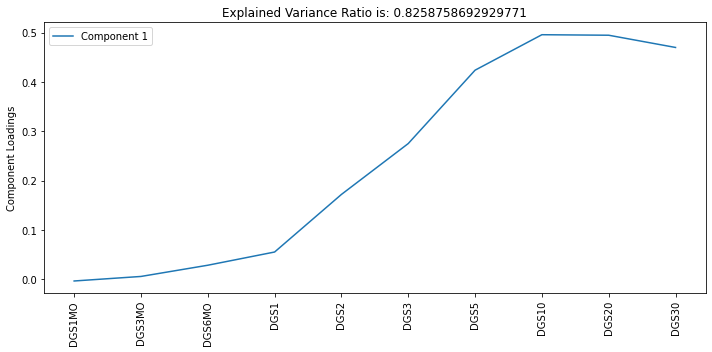

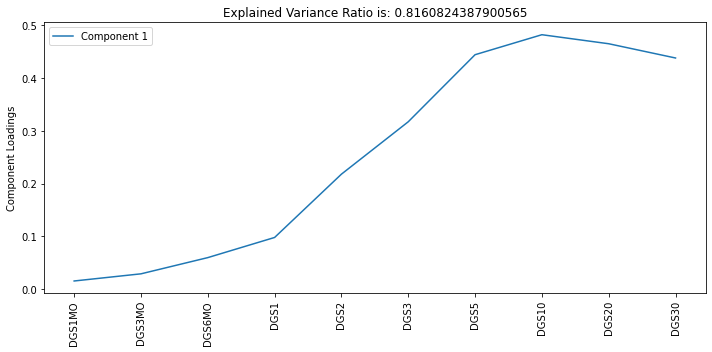

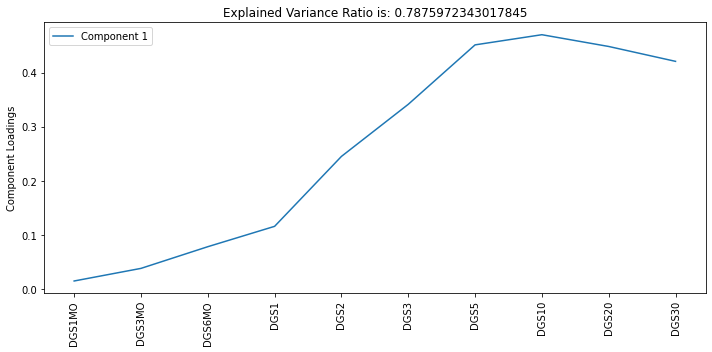

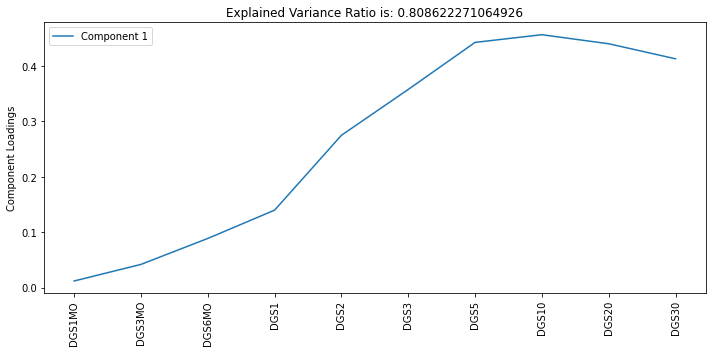

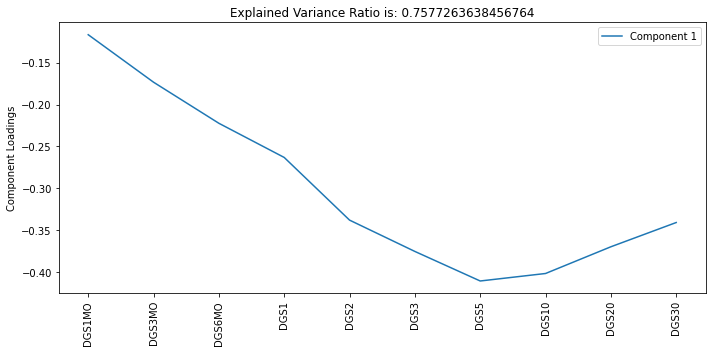

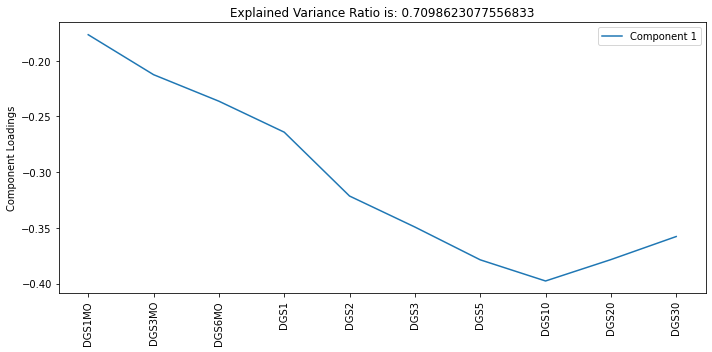

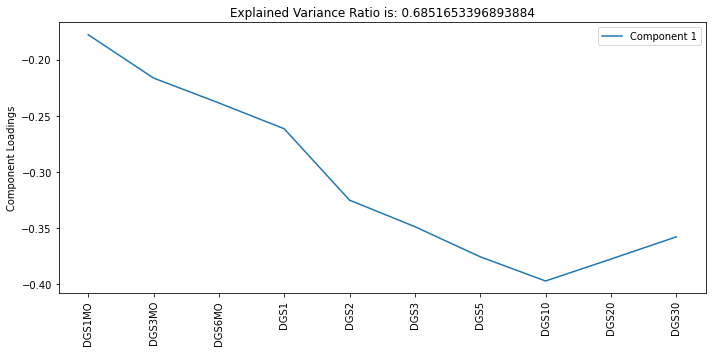

Pipeline(steps=[('get change', get_diff()),
                ('ts_pca',
                 Rolled_TS_PCA(n_components=1, n_splits=22, plot=True,
                               train_test_ratio=5))])

In [8]:
pipeline_e = Pipeline(steps=[
    ('get change', get_diff()), 
    ('ts_pca', Rolled_TS_PCA(n_splits=22, train_test_ratio=5, n_components=1, plot=True))
])

pipeline_e.fit(weekly_data)

#### We can see from the plot that the explained variance ratio can drop from 0.78 to 0.59 from the 6th to the 7th and afterwards. Besides, it increases from 0.56 to 0.84 again from 12th to 13th plot. 

## (f)

In [9]:
import numpy as np

res = {}
for n_splits in [22,44]:
    for train_test_ratio in [2,3,4,5]:
        pipeline_f = Pipeline(steps=[
            ('get change', get_diff()), 
            ('ts_pca', Rolled_TS_PCA(n_components=3,n_splits=n_splits,train_test_ratio=train_test_ratio,plot=False))])
        pipeline_f.fit(weekly_data)
        res[(n_splits,train_test_ratio)] = np.mean(pipeline_f[1].variance_explained_his)

        
best_params = max(res, key=res.get)

print('Best n_splits: ', best_params[0])
print('Best train_test_ratio: ', best_params[1])
print('Best average explained variance : ', res[best_params])

Best n_splits:  44
Best train_test_ratio:  2
Best average explained variance :  0.9671191135697303


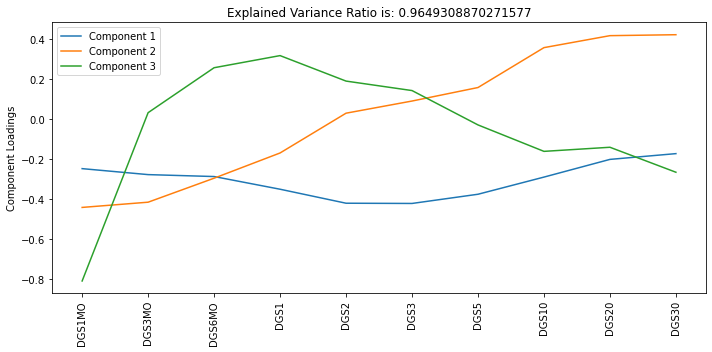

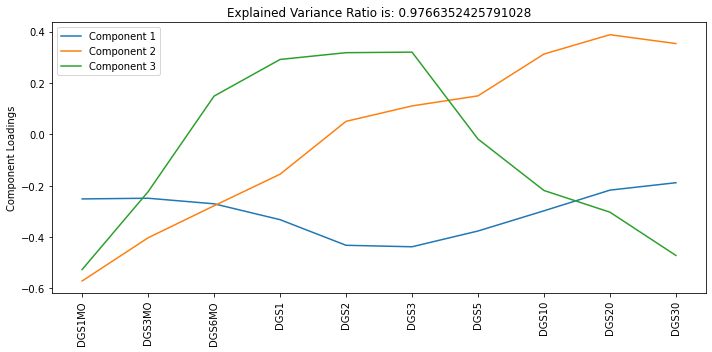

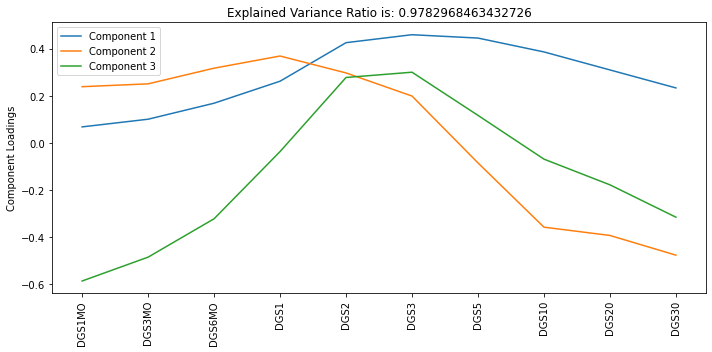

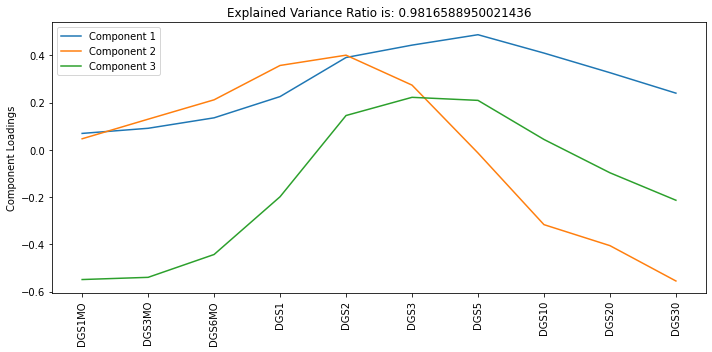

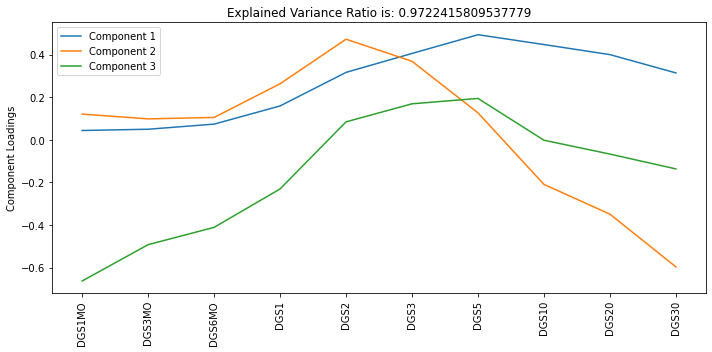

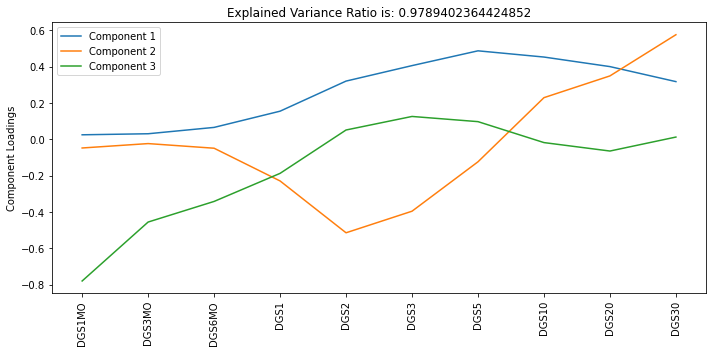

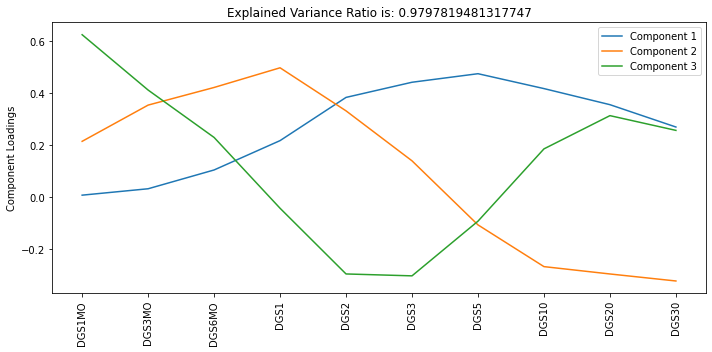

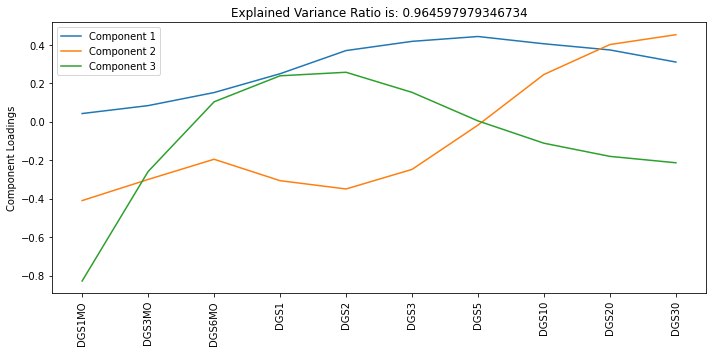

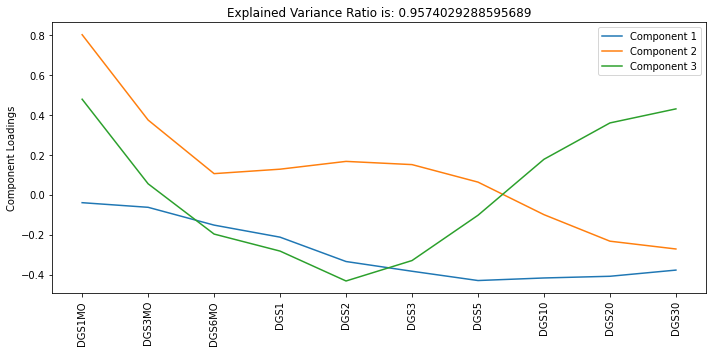

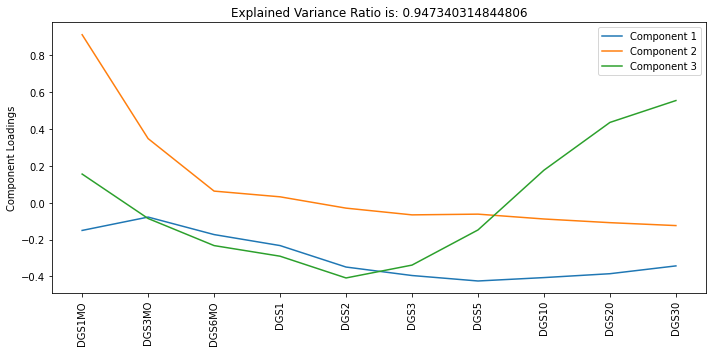

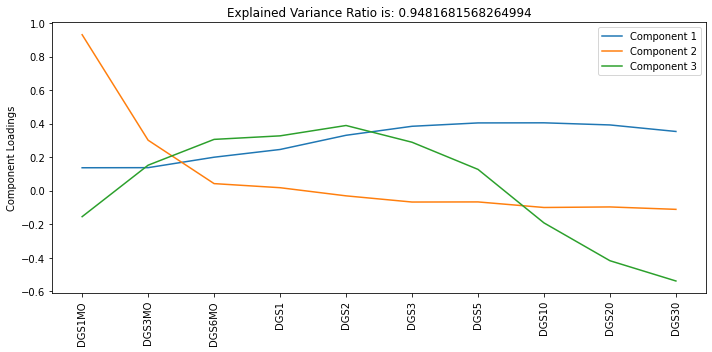

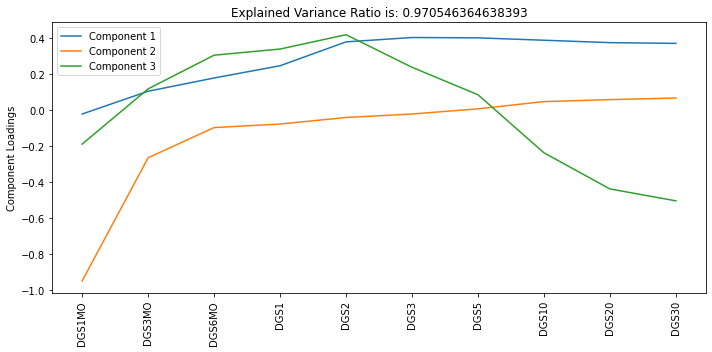

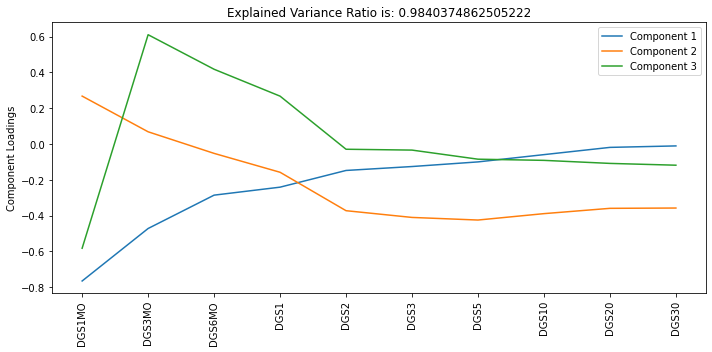

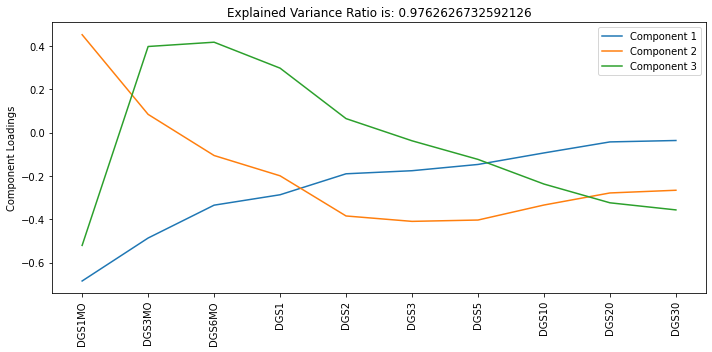

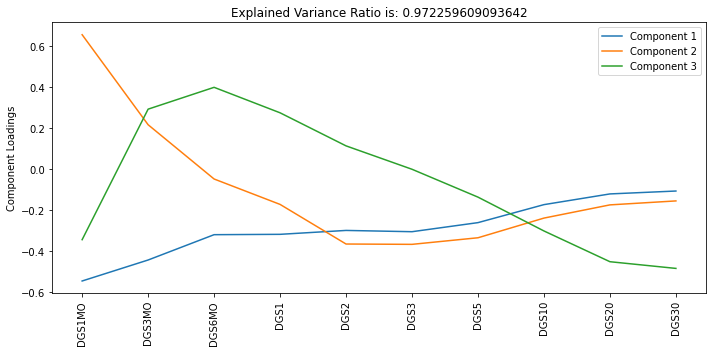

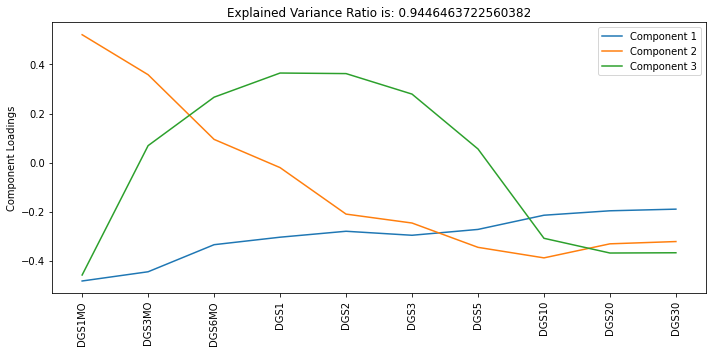

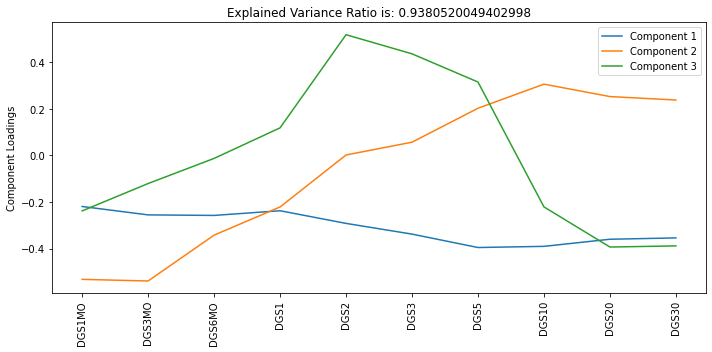

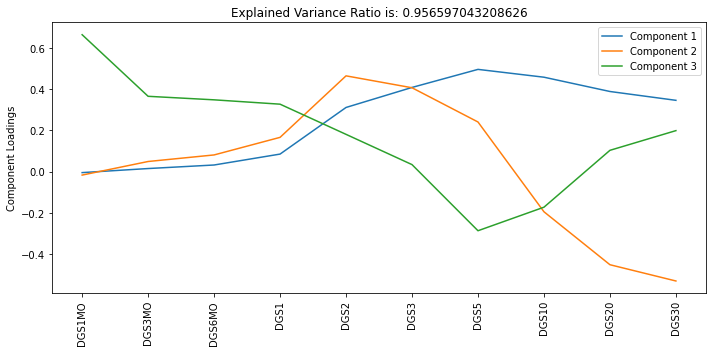

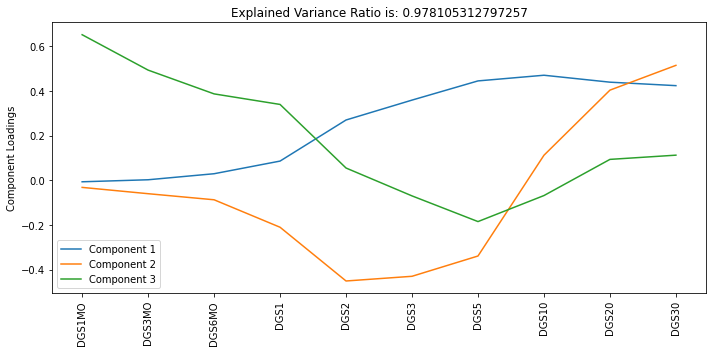

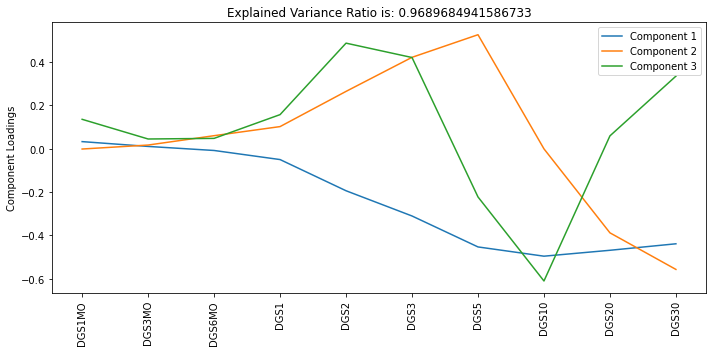

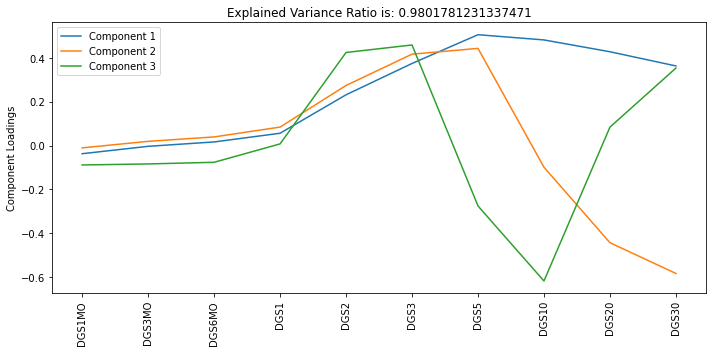

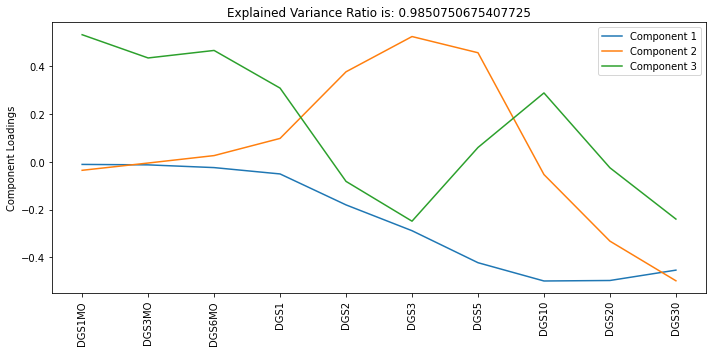

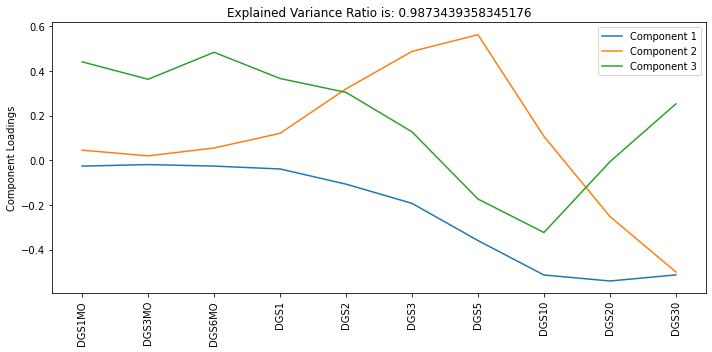

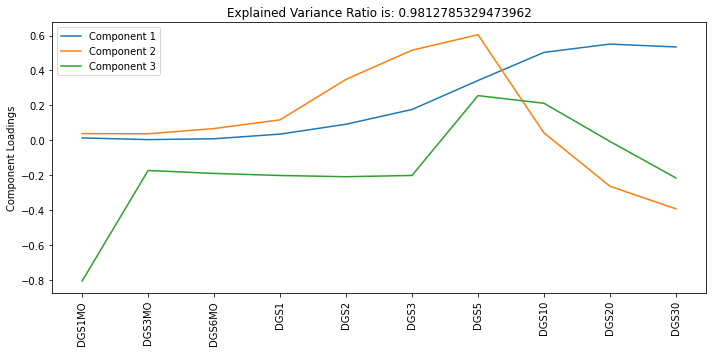

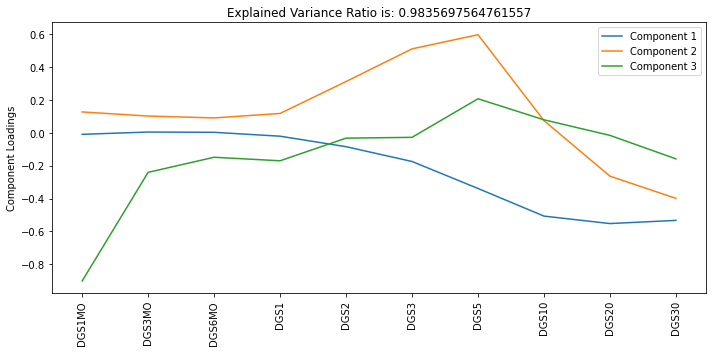

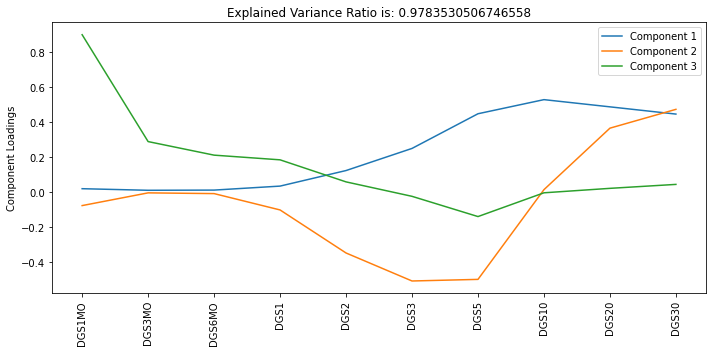

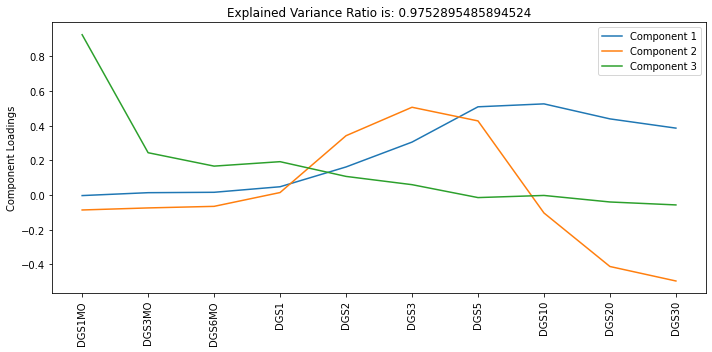

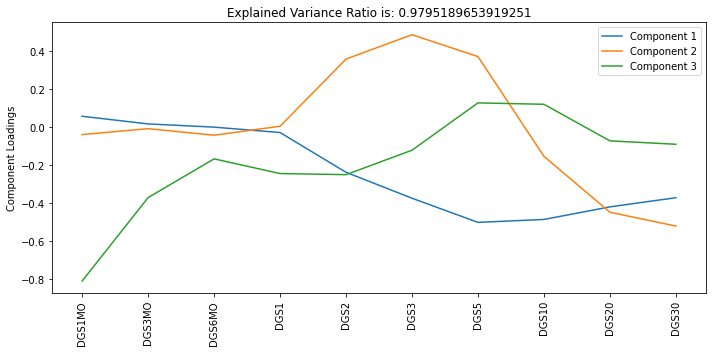

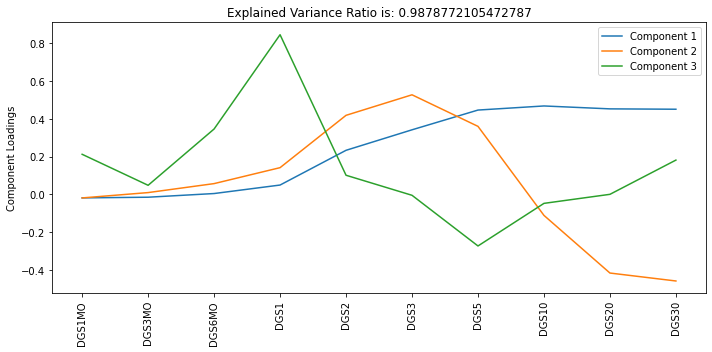

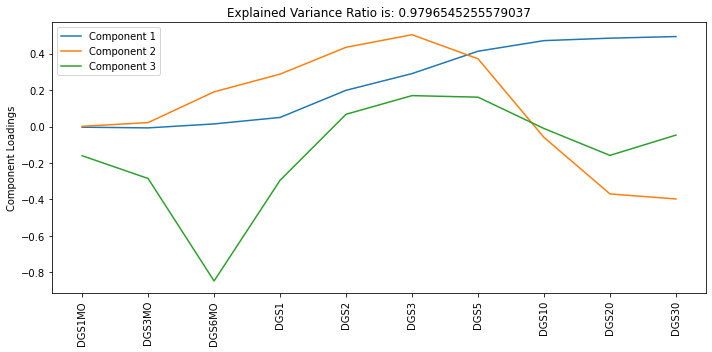

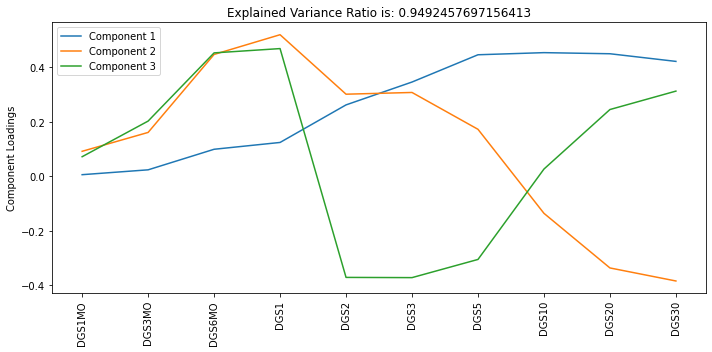

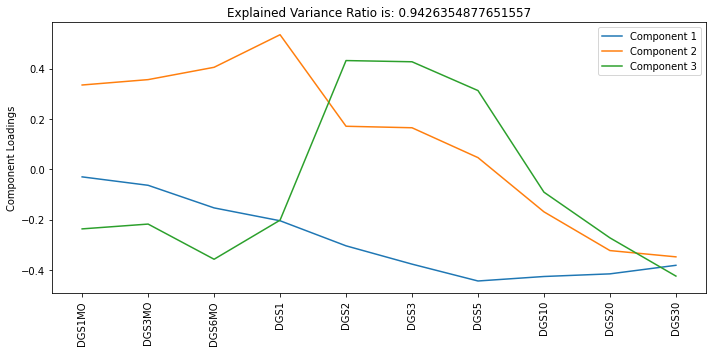

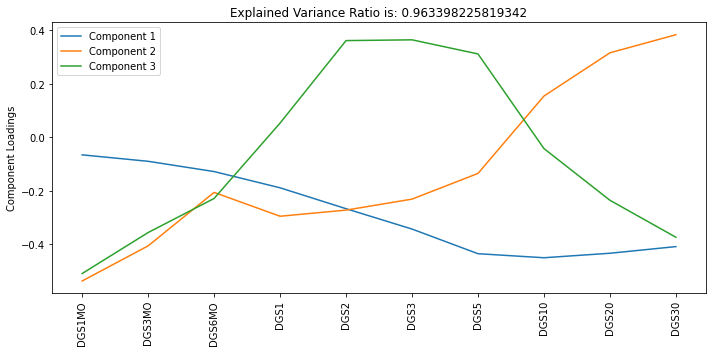

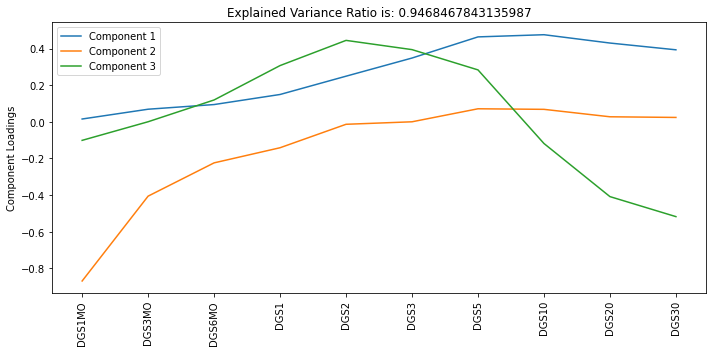

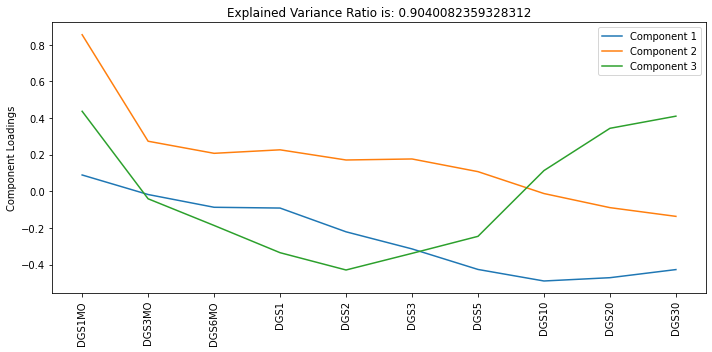

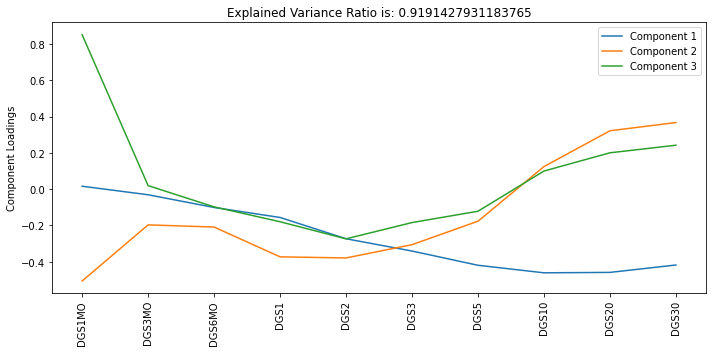

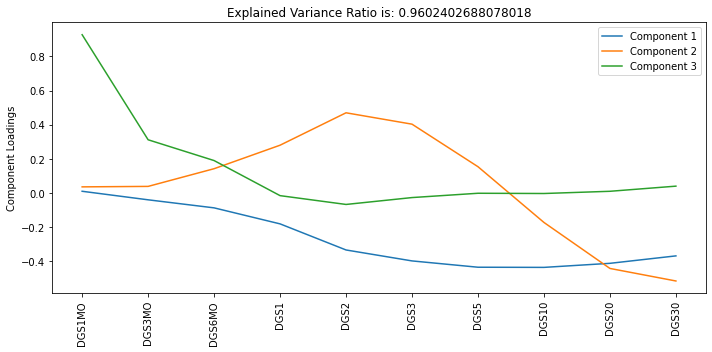

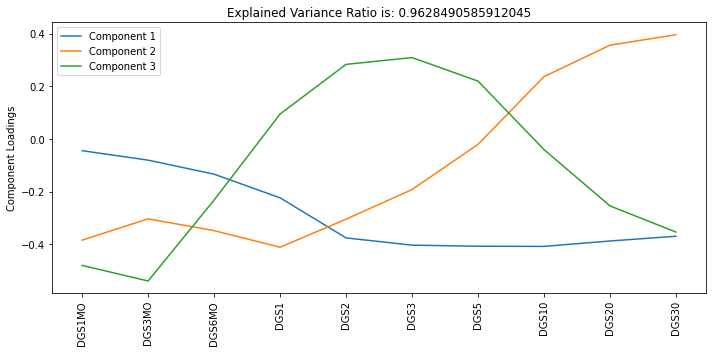

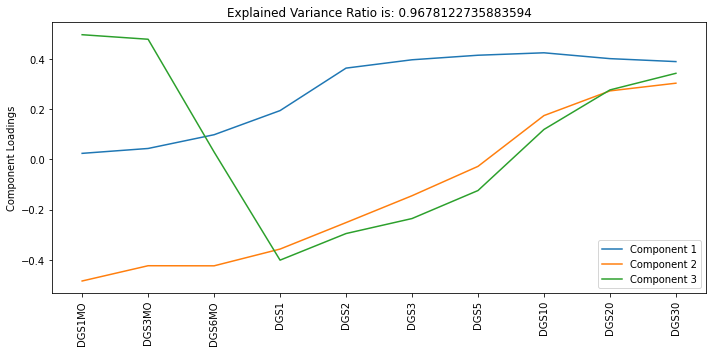

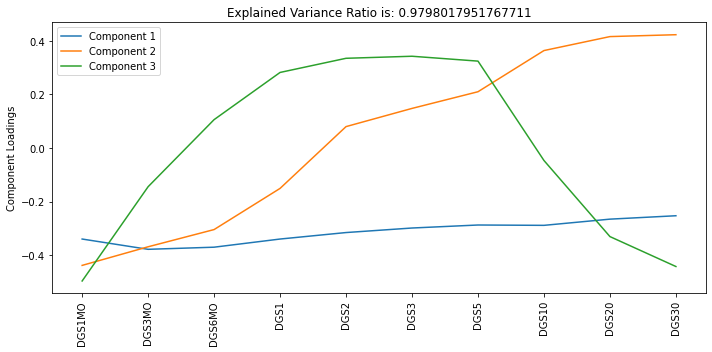

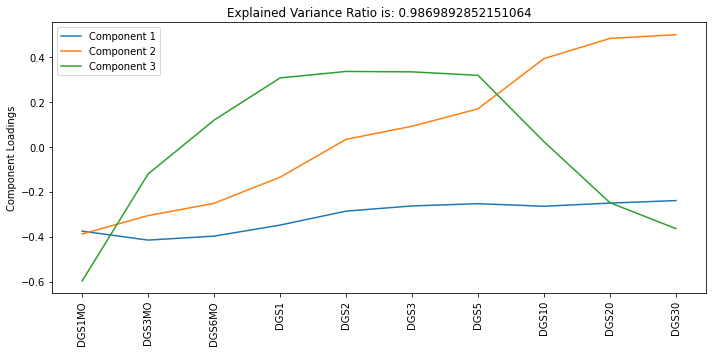

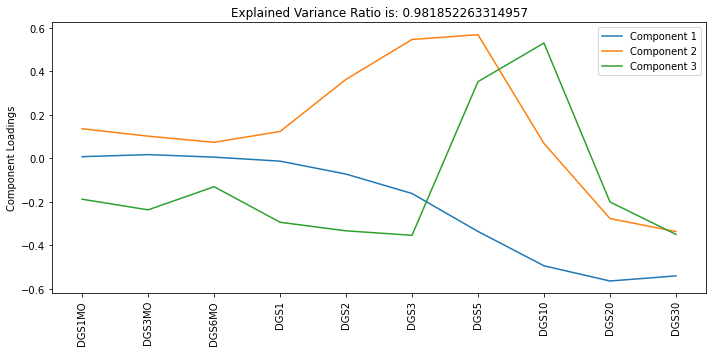

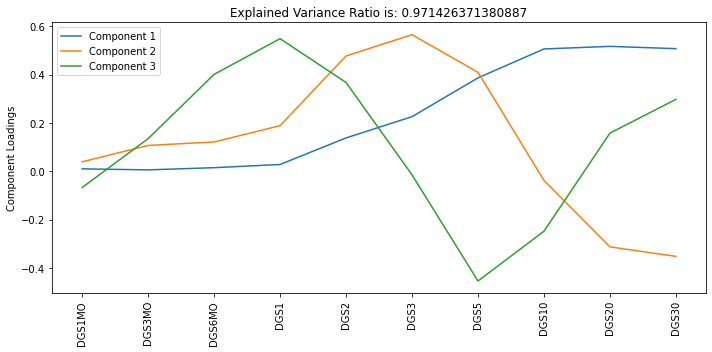

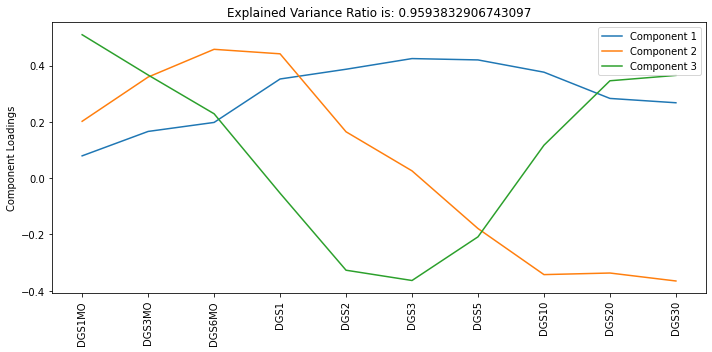

Pipeline(steps=[('get change', get_diff()),
                ('ts_pca',
                 Rolled_TS_PCA(n_components=3, n_splits=44, plot=True,
                               train_test_ratio=2))])

In [10]:
pipeline_f = Pipeline(steps=[
            ('get change', get_diff()), 
            ('ts_pca', Rolled_TS_PCA(n_components=3,n_splits=44,train_test_ratio=2,plot=True))])
pipeline_f.fit(weekly_data)